# covid19pt-forecasting

Blablabla

## Imports

In [1]:
import pandas as pd
import requests
import json

## Import data from DGS API

### API

In [2]:
response = requests.get("https://covid19-api.vost.pt/Requests/get_full_dataset")

In [3]:
data_dgs = response.json()

In [4]:
data_dgs_df = pd.DataFrame.from_dict(data_dgs)
data_dgs_df['data_dados'] = pd.to_datetime(data_dgs_df.data_dados, infer_datetime_format=True)
data_dgs_df = data_dgs_df.set_index('data_dados').sort_index()


In [5]:
display(data_dgs_df)

,data,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,...,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m,confirmados_desconhecidos_m,confirmados_desconhecidos_f,ativos
data_dados,,,,,,,,,,,,,,,,,,,,,
2020-02-26,26-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-27,27-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-28,28-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,29-02-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,01-03-2020,0,0,0,0,0,0,0,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-20,20-09-2020,68577,24795,5621,35004,1318,1392,243,204,NaN,...,115.0,150.0,231.0,714.0,561.0,949.0,963.0,NaN,NaN,21069.0
2020-09-21,21-09-2020,69200,24908,5651,35443,1340,1401,252,205,NaN,...,116.0,150.0,234.0,716.0,563.0,951.0,969.0,NaN,NaN,21544.0
2020-09-22,22-09-2020,69663,25099,5687,35641,1352,1422,254,208,NaN,...,116.0,150.0,235.0,718.0,565.0,953.0,972.0,NaN,NaN,21764.0


# Confirmed cases only

In [6]:
data_dgs_df_confirmed = data_dgs_df[['confirmados']]
# add missing days
all_days = pd.date_range(data_dgs_df_confirmed.index.min(), data_dgs_df_confirmed.index.max(), freq='D')
data_dgs_df_confirmed.reindex(all_days)

#data_dgs_df_confirmed = data_dgs_df_confirmed[data_dgs_df_confirmed['confirmados'] != 0] # drop days without information
display(data_dgs_df_confirmed)

,confirmados
data_dados,
2020-02-26,0
2020-02-27,0
2020-02-28,0
2020-02-29,0
2020-03-01,0
...,...
2020-09-20,68577
2020-09-21,69200
2020-09-22,69663


## Timeseries magic

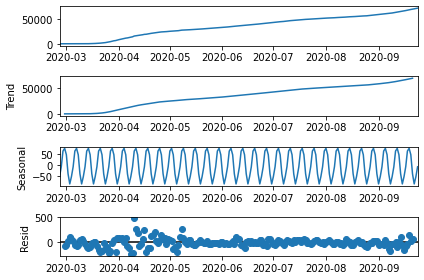

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

data_dgs_df_confirmed = data_dgs_df_confirmed.asfreq('d')
data_dgs_df_confirmed = data_dgs_df_confirmed.fillna(method='bfill').fillna(method='ffill')

decomposition = seasonal_decompose(data_dgs_df_confirmed,  model='additive') #period = 30 WHAT DOES PERIOD DO?
decomposition.plot()
plt.show() 

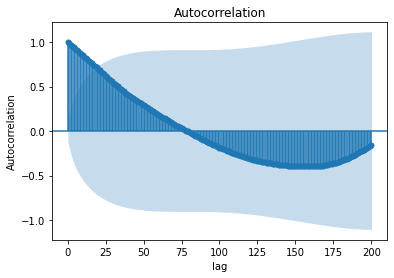

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_dgs_df_confirmed, alpha=0.05, lags=200)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

### Make data stationary

In [9]:
data_dgs_df_confirmed_detrend = data_dgs_df_confirmed.diff().dropna()

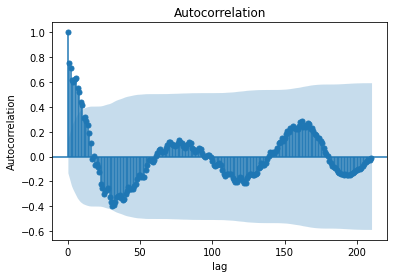

In [12]:
plot_acf(data_dgs_df_confirmed_detrend, alpha=0.05, lags=210)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

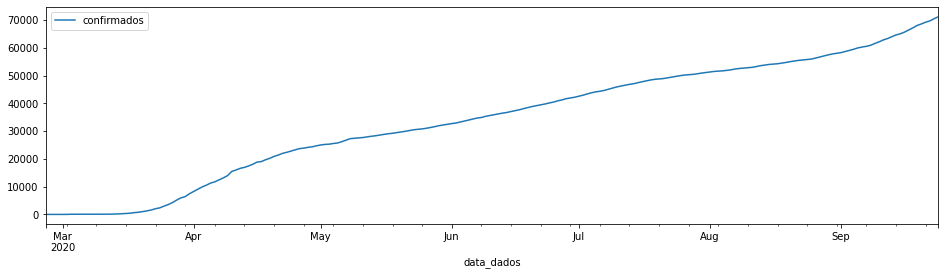

In [13]:
data_dgs_df_confirmed.plot(figsize=(16, 4));

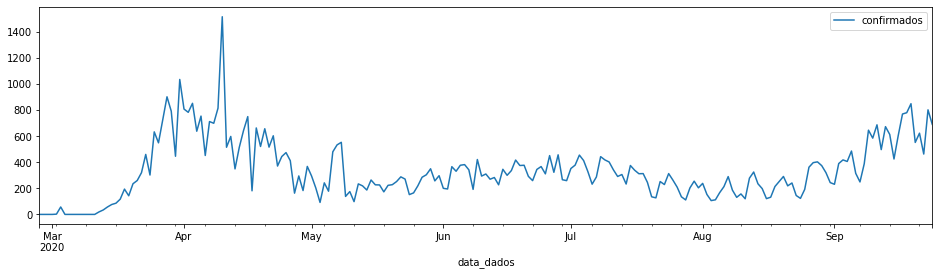

In [14]:
data_dgs_df_confirmed_detrend.plot(figsize=(16, 4));

In [24]:
import pmdarima as pm

sarimax = pm.AutoARIMA(seasonal=True, trace=True, supress_warnings=True, method='nm', maxiter=100, S=7)
sarimax.fit(data_dgs_df_confirmed_detrend)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2677.717, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2886.373, Time=0.04 sec


/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2707.176, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2802.095, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3134.233, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2675.743, Time=0.10 sec


/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2741.693, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2673.806, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=2677.965, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2679.421, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2675.024, Time=0.05 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.852 seconds


/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AutoARIMA(maxiter=100, method='nm', trace=True)

/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


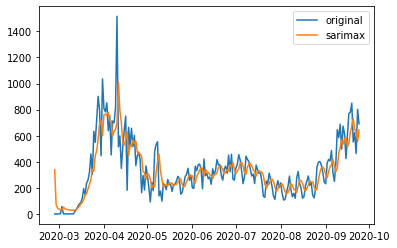

In [25]:
plt.plot(data_dgs_df_confirmed_detrend, label='original')
plt.plot(data_dgs_df_confirmed_detrend.index, sarimax.predict_in_sample(), label='sarimax')
plt.legend()

In [26]:
from sklearn.metrics import mean_absolute_error

predictions = sarimax.predict_in_sample()
mae = mean_absolute_error(predictions, data_dgs_df_confirmed_detrend)

/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/pmdarima/arima/arima.py:560: UserWarning: As of version 1.5.0 'typ' is no longer a valid arg for predict. In future versions this will raise a TypeError.
  warnings.warn("As of version 1.5.0 'typ' is no longer a valid "


In [27]:
mae

92.51560189761918

In [28]:
import numpy as np

sarimax_forecast_one_step_refit = []
# forecast next 60 days
for i in np.arange(0,120):
    next_step_forecast = sarimax.predict(1)[0]
    sarimax_forecast_one_step_refit.append(next_step_forecast)
    sarimax = sarimax.update(data_dgs_df_confirmed_detrend[i:i+1])

/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: Con

/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: Con

/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/cimendes/.virtualenvs/slu00/lib/python3.7/site-packages/statsmodels/base/model.py:568: Con

<AxesSubplot:>

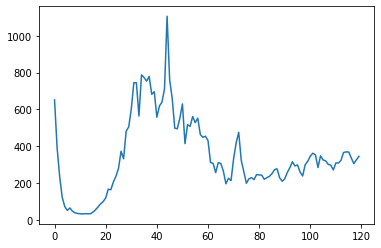

In [29]:
pd.Series(sarimax_forecast_one_step_refit).plot()

<AxesSubplot:>

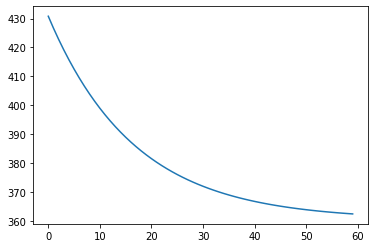

In [21]:
forecast = sarimax.predict(60)
pd.Series(forecast).plot()
